# COURSE: A deep understanding of deep learning
## SECTION: More on data
### LECTURE: Sample size and network depth
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# a function that creates data

def createSomeData(nPerClust):

  A = [ 1, 1 ]
  B = [ 5, 1 ]
  C = [ 4, 4 ]

  # generate data
  a = [ A[0]+np.random.randn(nPerClust) , A[1]+np.random.randn(nPerClust) ]
  b = [ B[0]+np.random.randn(nPerClust) , B[1]+np.random.randn(nPerClust) ]
  c = [ C[0]+np.random.randn(nPerClust) , C[1]+np.random.randn(nPerClust) ]

  # true labels
  labels_np = np.hstack(( np.zeros((nPerClust)),
                          np.ones( (nPerClust)),
                        1+np.ones( (nPerClust))  ))

  # concatanate into a matrix, then convert to a pytorch tensor
  data_np = np.hstack((a,b,c)).T

  # NEW: put all outputs into a dictionary
  output = {}
  output['data'] = torch.tensor(data_np).float()
  output['labels'] = torch.tensor(labels_np).long() # note: "long" format (integers) for labels

  # use scikitlearn to split the data
  train_data,test_data, train_labels,test_labels = train_test_split(output['data'], output['labels'], train_size=.9)

  # then convert them into PyTorch Datasets (note: already converted to tensors)
  train_data = TensorDataset(train_data,train_labels)
  test_data  = TensorDataset(test_data,test_labels)

  # finally, translate into dataloader objects
  batchsize  = 8
  output['train_data'] = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  output['test_data']  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

  return output

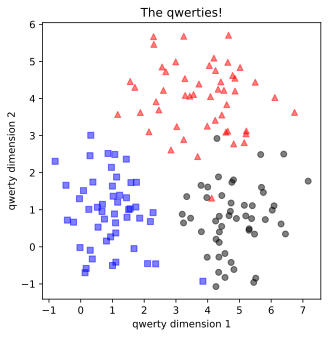

In [3]:
# Check that the function works

theData = createSomeData(50)

data = theData['data']
labels = theData['labels']

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Create the model

In [3]:
# create a class for the model
def createTheQwertyNet(nUnits,nLayers):

  class qwertyNet(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(2,nUnits)

      ### hidden layers
      for i in range(1,nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,3)


    # forward pass
    def forward(self,x):
      # input layer
      x = F.relu( self.layers['input'](x) )

      # hidden layers
      for i in range(1,self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )

      # return output layer
      x = self.layers['output'](x)
      return x

  # create the model instance
  net = qwertyNet(nUnits,nLayers)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [4]:
# test the model with fake input

nUnitsPerLayer = 12
nLayers = 4

net,lossf,opt = createTheQwertyNet(nUnitsPerLayer,nLayers)
print(net)

# input is ten samples
input = torch.rand(10,2)
net(input)

qwertyNet(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


tensor([[-0.0316,  0.0691,  0.3556],
        [-0.0337,  0.0685,  0.3563],
        [-0.0344,  0.0691,  0.3568],
        [-0.0339,  0.0686,  0.3564],
        [-0.0329,  0.0679,  0.3557],
        [-0.0308,  0.0685,  0.3550],
        [-0.0327,  0.0695,  0.3563],
        [-0.0325,  0.0688,  0.3559],
        [-0.0315,  0.0673,  0.3549],
        [-0.0340,  0.0685,  0.3564]], grad_fn=<AddmmBackward0>)

# Note:
### There was a bug in the code I used in the video, which a student caught (see Q&A for this lecture).
### This file is corrected, but it doesn't change the pattern or conclusion of the video.
### The code cell below confirms that the model preserves the number of total units while varying the number of layers.

In [5]:
# a function to count the number of units
def count_units(model):
  total_units = 0
  for layer in model.modules():
    if isinstance(layer, torch.nn.modules.linear.Linear):
      total_units += layer.in_features
  return total_units


nNodesInModel = 80
layersRange   = [ 1,5,10,20 ]

# print out the model architectures
for lidx,layers in enumerate(layersRange):

  # create a model
  unitsperlayer = int(nNodesInModel//layersRange[lidx])
  net = createTheQwertyNet(unitsperlayer,layers)[0]

  # count and print the results
  print(f'Units/layer: {unitsperlayer}, layers: {layers}, Total count: {count_units(net)}')

Units/layer: 80, layers: 1, Total count: 82
Units/layer: 16, layers: 5, Total count: 82
Units/layer: 8, layers: 10, Total count: 82
Units/layer: 4, layers: 20, Total count: 82


# A function that trains the model

In [6]:
def function2trainTheModel(nUnits,nLayers):

  # number of epochs
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(nUnits,nLayers)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_data:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_data)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


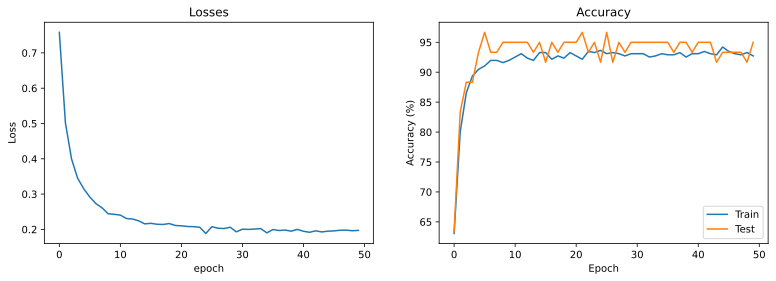

In [7]:
### Test the model once with a bit of data, just to make sure the code works.

# generate the data
theData = createSomeData(200)
train_data = theData['train_data']
test_data  = theData['test_data']

# run the model
trainAcc,testAcc,losses,net = function2trainTheModel(80,1)



# show the results!
fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

# Now for the experiment!

In [8]:
# before the experiment, configure and confirm the metaparameters

# specify the parameters for the model
nNodesInModel = 80
layersRange   = [ 1,5,10,20 ]
nDatapoints   = np.arange(50,551,50)

# create a legend for later plotting
legend = []

# print out the model architectures
for lidx,layers in enumerate(layersRange):

  # create a model
  unitsperlayer = int(nNodesInModel/layersRange[lidx])
  net = createTheQwertyNet(unitsperlayer,layers)[0]

  # count its parameters (see lecture ANNs:Depth vs. breadth)
  nparams = np.sum([ p.numel() for p in net.parameters() if p.requires_grad ])

  legend.append( '%s layers, %s units, %s params' %(layers,unitsperlayer,nparams) )
  print('This model will have %s layers, each with %s units, totalling %s parameters' %(layers,unitsperlayer,nparams))

This model will have 1 layers, each with 80 units, totalling 483 parameters
This model will have 5 layers, each with 16 units, totalling 1187 parameters
This model will have 10 layers, each with 8 units, totalling 699 parameters
This model will have 20 layers, each with 4 units, totalling 407 parameters


In [9]:
# note: takes ~5 mins

# initialize results matrix
results = np.zeros((len(nDatapoints),len(layersRange),2))

for didx,pnts in enumerate(nDatapoints):

  # create data (note: same data for each layer manipulation!)
  theData = createSomeData(pnts)
  train_data = theData['train_data']
  test_data  = theData['test_data']


  # now loop over layers
  for lidx,layers in enumerate(layersRange):

    unitsperlayer = int(nNodesInModel/layersRange[lidx])
    trainAcc,testAcc,losses,net = function2trainTheModel(unitsperlayer,layers)

    # average of last 5 accuracies and losses
    results[didx,lidx,0] = np.mean( testAcc[-5:] )
    results[didx,lidx,1] = torch.mean(losses[-5:]).item()

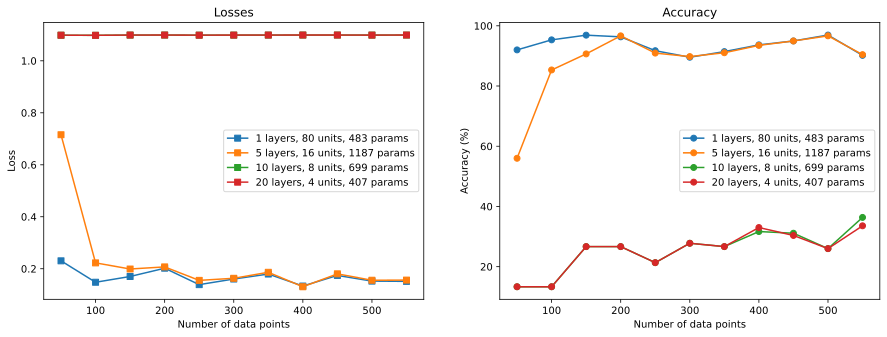

In [10]:
# show the results!

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(nDatapoints,results[:,:,1],'s-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Number of data points')
ax[0].legend(legend)
ax[0].set_title('Losses')

ax[1].plot(nDatapoints,results[:,:,0],'o-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Number of data points')
ax[1].set_title('Accuracy')
ax[1].legend(legend)
plt.show()


In [ ]:
# Interpretation:
#   Learning depends more on the architecture and the nature of the problem, than on the number of parameters.

# Additional explorations

In [ ]:
# 1) The model learns faster and better with the Adam optimizer. In fact, I intentionally used SGD here to make the
#    model worse for this demonstration! Change the optimizer to Adam. What do you think is a good learning rate?
#    More importantly: Do the conclusions of this experiment hold for the Adam optimizer?
#
# 2) Add a timer to the experiment loop. Does the training duration relate to the number of layers or the number
#    of parameters?
#
# 3) Do the two deepest models eventually learn if you increase the number of training epochs? (Note: because this
#    question is only about the deepest models and because training time will increase, you need only test the two
#    models, not all four.)
#